# LT Machine Learning

Analyze with auto-ML Laughing Together data

## 1. Import and prepare data

The data will have this format: 
- features:
    - for each participant, coherence for each channel combination (one value per channel combination - 10 in total)
    - liking pre (average of scores)
    - liking post (average of scores)
    - laughter group (laughter, control)
    - interaction group (interaction, control)
    - big 5 (5 in total)
- outcome:
    - joint action performance in Castle Knight

### 1.1 Try with simulated data first. Create data

In [1]:
import numpy as np
import pandas as pd

# Set random seed for replicability
np.random.seed(42)

# Parameters
n_pairs = 50  # Number of pairs (total participants = n_pairs * 2)
n_participants = n_pairs * 2
n_channel_combinations = 10  # Number of channel combinations

# Simulating data
coherence_values = np.repeat(
    [np.random.rand(n_channel_combinations) for _ in range(n_pairs)], 2, axis=0
)  # Coherence values for each pair, repeated for both participants

data = {
    # Pair IDs repeated twice (e.g., 1,1,2,2,3,3,...)
    "pair_id": np.repeat(np.arange(1, n_pairs + 1), 2),
    
    # Alternate "A" and "B" for participants within each pair
    "participant_id": np.tile(["A", "B"], n_pairs),
    
    # Liking pre/post scores (individual-level)
    "liking_pre": np.random.uniform(1, 7, n_participants),  # Liking scores pre (1-7 scale)
    "liking_post": np.random.uniform(1, 7, n_participants),  # Liking scores post (1-7 scale)
    
    # Laughter group, balanced and repeated for pairs
    "laughter_group": np.repeat(
        np.random.permutation(
            ["laughter"] * (n_pairs // 2) + ["control"] * (n_pairs // 2)
        ),
        2,
    ),
    
    # Interaction group, balanced and repeated for pairs
    "interaction_group": np.repeat(
        np.random.permutation(
            ["interaction"] * (n_pairs // 2) + ["control"] * (n_pairs // 2)
        ),
        2,
    ),
    
    # Big 5 personality traits (individual-level)
    "big_5_openness": np.random.normal(50, 10, n_participants),  # Openness
    "big_5_conscientiousness": np.random.normal(50, 10, n_participants),  # Conscientiousness
    "big_5_extraversion": np.random.normal(50, 10, n_participants),  # Extraversion
    "big_5_agreeableness": np.random.normal(50, 10, n_participants),  # Agreeableness
    "big_5_neuroticism": np.random.normal(50, 10, n_participants),  # Neuroticism
}

# Convert coherence values into a numpy array for processing
coherence_array = np.array(coherence_values)

# Generate joint action performance for each pair, then repeat for both participants
pair_performance = (
    0.3 * coherence_array[::2].mean(axis=1)  # Take coherence mean per pair
    + 0.2 * (np.mean(data["liking_post"].reshape(n_pairs, 2), axis=1) - np.mean(data["liking_pre"].reshape(n_pairs, 2), axis=1))
    + 0.1 * (np.mean(data["big_5_extraversion"].reshape(n_pairs, 2), axis=1) - 50)
    + np.random.normal(0, 5, n_pairs)  # Random noise per pair
)
data["joint_action_performance"] = np.repeat(pair_performance, 2)

# Convert to DataFrame without coherence values
df = pd.DataFrame(data)

# Expand coherence values into separate columns and merge with the main DataFrame
coherence_df = pd.DataFrame(coherence_array, columns=[f"coherence_ch{i+1}" for i in range(n_channel_combinations)])
df = pd.concat([df, coherence_df], axis=1)

# Display first few rows
print(df.head())


   pair_id participant_id  liking_pre  liking_post laughter_group  \
0        1              A    5.188970     2.013610       laughter   
1        1              B    4.216578     2.671542       laughter   
2        2              A    2.857166     2.062063        control   
3        2              B    5.882770     1.532215        control   
4        3              A    5.108387     1.723815       laughter   

  interaction_group  big_5_openness  big_5_conscientiousness  \
0           control       45.031410                50.255713   
1           control       53.878449                35.891495   
2           control       56.587051                32.914967   
3           control       40.908424                60.103450   
4       interaction       66.420962                59.627907   

   big_5_extraversion  big_5_agreeableness  ...  coherence_ch1  coherence_ch2  \
0           46.896544            38.311037  ...       0.374540       0.950714   
1           51.156848            42.57

### 1.2 Explore data

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pair_id                   100 non-null    int32  
 1   participant_id            100 non-null    object 
 2   liking_pre                100 non-null    float64
 3   liking_post               100 non-null    float64
 4   laughter_group            100 non-null    object 
 5   interaction_group         100 non-null    object 
 6   big_5_openness            100 non-null    float64
 7   big_5_conscientiousness   100 non-null    float64
 8   big_5_extraversion        100 non-null    float64
 9   big_5_agreeableness       100 non-null    float64
 10  big_5_neuroticism         100 non-null    float64
 11  joint_action_performance  100 non-null    float64
 12  coherence_ch1             100 non-null    float64
 13  coherence_ch2             100 non-null    float64
 14  coherence_c

In [3]:
df.shape

(100, 22)

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pair_id,100.0,25.500000,14.503570,1.000000,13.000000,25.500000,38.000000,50.000000
liking_pre,100.0,4.151798,1.782733,1.087268,2.533122,4.169212,5.866842,6.998306
liking_post,100.0,3.589519,1.604066,1.120427,2.209067,3.325419,4.675172,6.919091
big_5_openness,100.0,49.905853,11.039938,22.153644,42.771573,49.246076,56.636877,79.761969
big_5_conscientiousness,100.0,52.072867,10.391853,22.159958,45.278902,51.950332,59.685237,73.029119
big_5_extraversion,100.0,50.806790,11.433467,26.283843,43.361468,49.621298,56.260024,81.673717
big_5_agreeableness,100.0,50.955767,9.643141,25.187050,44.229459,49.697713,57.311630,75.155462
big_5_neuroticism,100.0,51.900988,11.851775,23.901582,43.063748,51.758320,60.771483,81.048674
joint_action_performance,100.0,-0.046058,4.498188,-9.992660,-3.388471,0.360195,2.802895,10.515502
coherence_ch1,100.0,0.467819,0.305599,0.012154,0.122038,0.447314,0.772245,0.990505


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame for grouped visualization
df_melted = df.melt(
    id_vars=["laughter_group", "interaction_group"],
    value_vars=[
        "liking_pre", "liking_post", "big_5_openness", "big_5_conscientiousness",
        "big_5_extraversion", "big_5_agreeableness", "big_5_neuroticism",
        "joint_action_performance"
    ],
    var_name="variable",
    value_name="value"
)

df_melted.head()


,laughter_group,interaction_group,variable,value
0,laughter,control,liking_pre,5.188970
1,laughter,control,liking_pre,4.216578
2,control,control,liking_pre,2.857166
3,control,control,liking_pre,5.882770
4,laughter,interaction,liking_pre,5.108387


C:\Users\Admin\AppData\Local\Temp\ipykernel_6376\2084587557.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6376\2084587557.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


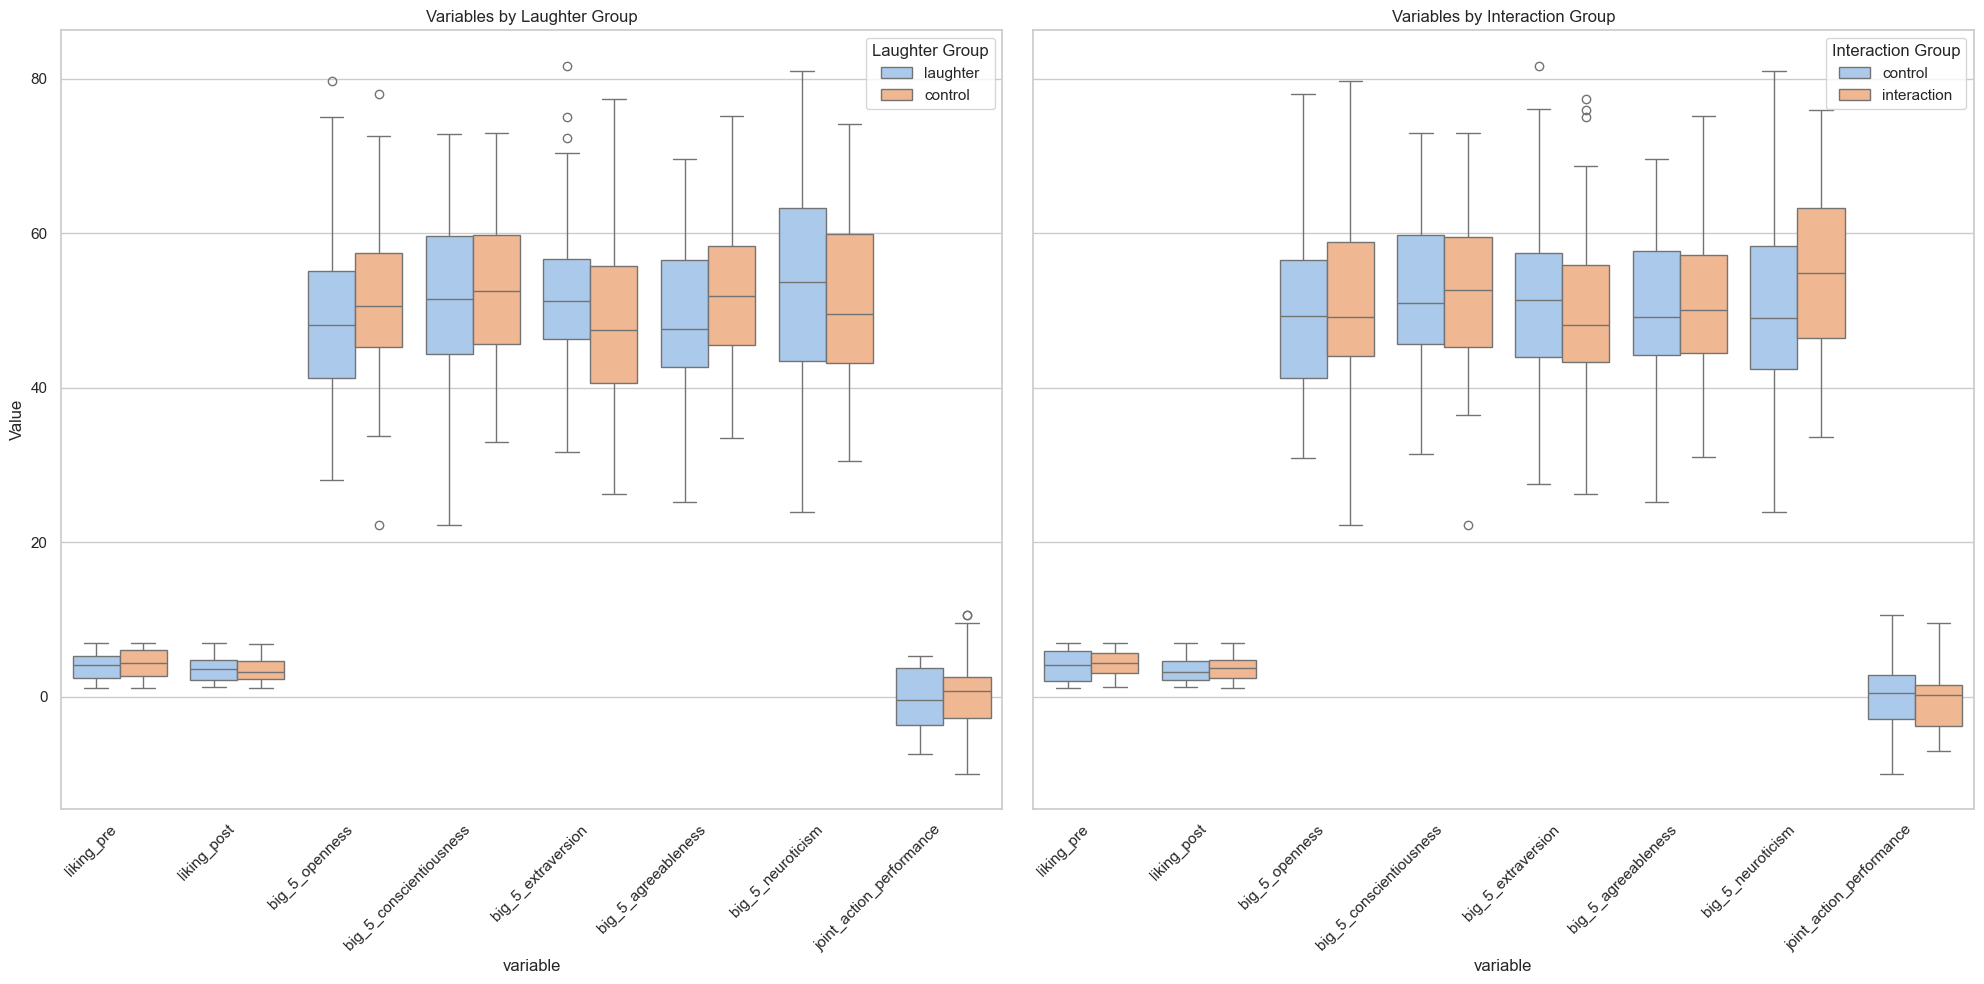

In [7]:
# Set the overall style
sns.set(style="whitegrid", palette="pastel")

# Create subplots for each group
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Plot by laughter group
sns.boxplot(
    data=df_melted, x="variable", y="value", hue="laughter_group", ax=axes[0]
)
axes[0].set_title("Variables by Laughter Group")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
axes[0].set_ylabel("Value")

# Plot by interaction group
sns.boxplot(
    data=df_melted, x="variable", y="value", hue="interaction_group", ax=axes[1]
)
axes[1].set_title("Variables by Interaction Group")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
axes[1].set_ylabel("Value")

# Add a legend to each plot
axes[0].legend(title="Laughter Group")
axes[1].legend(title="Interaction Group")

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
# Set pair_id and participant_id as indexes

# Set both pair_id and participant_id as index variables
df.set_index(["pair_id", "participant_id"], inplace=True)

# make both group variables as categorical
df['laughter_group'] = df['laughter_group'].astype('category')
df['interaction_group'] = df['interaction_group'].astype('category')


# Display the updated DataFrame with multi-index
print(df.head())


                        liking_pre  liking_post laughter_group  \
pair_id participant_id                                           
1       A                 5.188970     2.013610       laughter   
        B                 4.216578     2.671542       laughter   
2       A                 2.857166     2.062063        control   
        B                 5.882770     1.532215        control   
3       A                 5.108387     1.723815       laughter   

                       interaction_group  big_5_openness  \
pair_id participant_id                                     
1       A                        control       45.031410   
        B                        control       53.878449   
2       A                        control       56.587051   
        B                        control       40.908424   
3       A                    interaction       66.420962   

                        big_5_conscientiousness  big_5_extraversion  \
pair_id participant_id                       

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 100 entries, (1, 'A') to (50, 'B')
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   liking_pre                100 non-null    float64 
 1   liking_post               100 non-null    float64 
 2   laughter_group            100 non-null    category
 3   interaction_group         100 non-null    category
 4   big_5_openness            100 non-null    float64 
 5   big_5_conscientiousness   100 non-null    float64 
 6   big_5_extraversion        100 non-null    float64 
 7   big_5_agreeableness       100 non-null    float64 
 8   big_5_neuroticism         100 non-null    float64 
 9   joint_action_performance  100 non-null    float64 
 10  coherence_ch1             100 non-null    float64 
 11  coherence_ch2             100 non-null    float64 
 12  coherence_ch3             100 non-null    float64 
 13  coherence_ch4             100 non-nul

In [10]:
# save data for later use
filename_data = "Y:\Documents\Projects\LT_machine_learning\Data\simulated_LT_data"
df.to_csv(filename_data, index=True)

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Admin\AppData\Local\Temp\ipykernel_6376\2415504022.py:2: SyntaxWarning: invalid escape sequence '\D'
  filename_data = "Y:\Documents\Projects\LT_machine_learning\Data\simulated_LT_data"


## 2. Auto ML

### 2.1 Create test and train data

In [11]:
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_csv(filename_data)

# Shuffle and split the dataset into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)  # 80% train, 20% test

# Check the resulting shapes
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (80, 22)
Test data shape: (20, 22)


### 2.2 AutoGluon regressor

In [15]:
from autogluon.tabular import TabularPredictor

save_path = "Y:\Documents\Projects\LT_machine_learning\Models\Simulated_data"  # Replace this with the desired folder path

predictor = TabularPredictor(label="joint_action_performance",
                             eval_metric="mean_absolute_percentage_error", path=save_path).fit(train_data, time_limit=500, )

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Admin\AppData\Local\Temp\ipykernel_6376\1440635993.py:3: SyntaxWarning: invalid escape sequence '\D'
  save_path = "Y:\Documents\Projects\LT_machine_learning\Models\Simulated_data"  # Replace this with the desired folder path
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       19.11 GB / 31.71 GB (60.3%)
Disk Space Avail:   6.31 GB / 9.77 GB (64.7%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/t

In [ ]:
# here is the code if I wanted to pre-set the hyperparameter

from autogluon.tabular import TabularPredictor

# Define custom hyperparameters
hyperparameters = {
    'NN_TORCH': [{}],  # Use the default settings for NN_TORCH
    'GBM': [
        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},  # Ensure ag_args is a dict
        {'learning_rate': 0.03, 'num_leaves': 128, 'feature_fraction': 0.9, 'min_data_in_leaf': 3, 'ag_args': {'name_suffix': 'Large', 'priority': 0}},
    ],
    'CAT': [{}],
    'XGB': [{}],
    'FASTAI': [{}],
    'RF': [
        {'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}},
    ],
    'XT': [
        {'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}},
    ],
    'KNN': [
        {'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
        {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}
    ],
}

# Now use these hyperparameters when fitting the model
predictor = TabularPredictor(label="joint_action_performance",
                             eval_metric="mean_absolute_percentage_error").fit(
    train_data, time_limit=500, hyperparameters=hyperparameters
)



In [16]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.604582,mean_absolute_percentage_error,0.052431,1.042256,0.000000,0.069035,2,True,12
1,LightGBM,-0.688117,mean_absolute_percentage_error,0.006526,0.440035,0.006526,0.440035,1,True,4
2,XGBoost,-0.738262,mean_absolute_percentage_error,0.004529,0.550925,0.004529,0.550925,1,True,9
3,LightGBMLarge,-0.964691,mean_absolute_percentage_error,0.005001,0.518812,0.005001,0.518812,1,True,11
4,RandomForestMSE,-1.065456,mean_absolute_percentage_error,0.045905,0.533185,0.045905,0.533185,1,True,5
5,LightGBMXT,-1.232410,mean_absolute_percentage_error,0.005002,0.428381,0.005002,0.428381,1,True,3
6,ExtraTreesMSE,-1.385153,mean_absolute_percentage_error,0.052998,0.527229,0.052998,0.527229,1,True,7
7,NeuralNetTorch,-1.724467,mean_absolute_percentage_error,0.005002,0.569126,0.005002,0.569126,1,True,10
8,CatBoost,-1.798547,mean_absolute_percentage_error,0.001929,1.278406,0.001929,1.278406,1,True,6
9,NeuralNetFastAI,-3.566528,mean_absolute_percentage_error,0.005520,0.683642,0.005520,0.683642,1,True,8


### 2.3 Test the model

In [17]:
from autogluon.tabular import TabularPredictor
pred = TabularPredictor.load(save_path)

In [18]:
preds = pred.predict( test_data, model="WeightedEnsemble_L2" )
preds

83   -0.299580
53    0.190453
70   -0.434428
45    0.720076
44    0.596954
39   -0.389381
22   -0.170437
80    0.032826
10    0.714559
0    -0.528624
18    0.428932
30    1.266165
73    0.137155
33   -0.307968
90    1.145012
4    -0.269993
76   -0.238966
77   -0.284099
12   -0.553985
31    1.212829
Name: joint_action_performance, dtype: float32

In [19]:
metrics_data = pred.evaluate_predictions(test_data["joint_action_performance"], preds)
metrics_data

{'mean_absolute_percentage_error': -1.1159733572279646,
 'root_mean_squared_error': -5.037770001288223,
 'mean_squared_error': -25.37912658587954,
 'mean_absolute_error': -3.9450542756405733,
 'r2': -0.8636374860750584,
 'pearsonr': 0.009059138717566195,
 'median_absolute_error': -3.205196084359616}

### 2.4 Visualize the model

In [20]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor.load(save_path)
path_to_png = predictor.plot_ensemble_model()
path_to_png

'Y:\\Documents\\Projects\\LT_machine_learning\\Models\\Simulated_data\\ensemble_model.png'

## 3. Calculate feature importance

In [21]:
feature_importances = pred.feature_importance(test_data, model="WeightedEnsemble_L2", num_shuffle_sets=5)
feature_importances

Computing feature importance via permutation shuffling for 21 features using 20 rows with 5 shuffle sets...
	72.52s	= Expected runtime (14.5s per shuffle set)
	1.5s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
coherence_ch1,0.354092,0.399196,0.059169,5,1.176042,-0.467858
coherence_ch10,0.150149,0.040705,0.000589,5,0.233962,0.066336
coherence_ch7,0.046914,0.104562,0.186252,5,0.262210,-0.168381
coherence_ch4,0.031189,0.011083,0.001629,5,0.054008,0.008369
coherence_ch5,0.030280,0.036273,0.067679,5,0.104966,-0.044406
coherence_ch2,0.023063,0.014115,0.010850,5,0.052125,-0.005999
big_5_agreeableness,0.018843,0.035160,0.148467,5,0.091238,-0.053553
pair_id,0.004940,0.007238,0.100827,5,0.019843,-0.009962
interaction_group,0.002459,0.005545,0.188739,5,0.013877,-0.008958
laughter_group,0.001645,0.001912,0.063354,5,0.005582,-0.002292
